
=== Precios y salarios de equilibrio ===
p1 (numeraire) = 1.0000
p2             = 0.8401
w_L            = 0.5019
w_K            = 0.5228

=== Producción (outputs) ===
Y1 (bien g1)   = 46.0286
Y2 (bien g2)   = 67.1822

=== Demanda agregada por bien (debe igualar output por Walras) ===
Demanda total g1: 46.0286
Demanda total g2: 67.1822

=== Ingresos de hogares ===
I_h1 = 50.8189
I_h2 = 51.6519

=== Uso de factores por firma ===
f1: L=55.0207, K=35.2191
f2: L=44.9793, K=64.7809

=== Chequeo contable SAM (filas vs columnas) ===
    Ingresos(fila)  Pagos(col)           Dif
f1       46.028551   46.028551 -7.105427e-15
f2       56.442251   56.442251 -4.135359e-12
L        50.194031   50.194031  8.562040e-12
K        52.276771   52.276771 -4.412470e-12
h1       50.818853   50.818853  0.000000e+00
h2       51.651949   51.651949  0.000000e+00

=== SAM simbólica compacta (estructural) ===
                                                Hogar h1  \
salarios (L)                                   

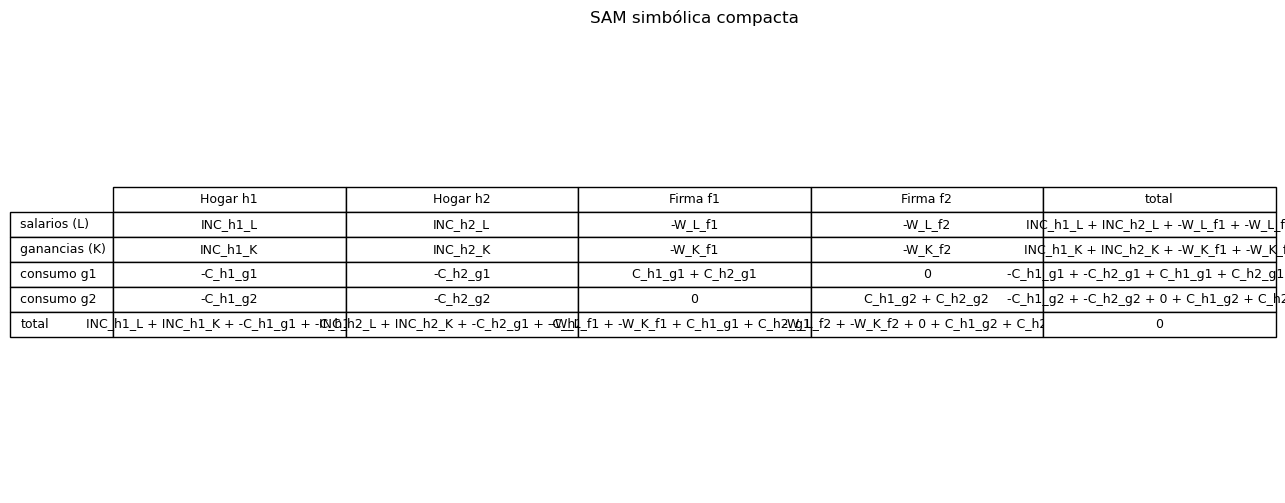


=== SAM numérica compacta ===
                Hogar h1   Hogar h2      Firma f1      Firma f2         total
salarios (L)   35.135822  15.058209 -2.761713e+01 -2.257690e+01 -8.558487e-12
ganancias (K)  15.683031  36.593740 -1.841142e+01 -3.386535e+01  4.412470e-12
consumo g1    -27.950369 -18.078182  4.602855e+01  0.000000e+00  0.000000e+00
consumo g2    -22.868484 -33.573767  0.000000e+00  5.644225e+01  0.000000e+00
total           0.000000   0.000000 -7.105427e-15 -4.135359e-12  0.000000e+00


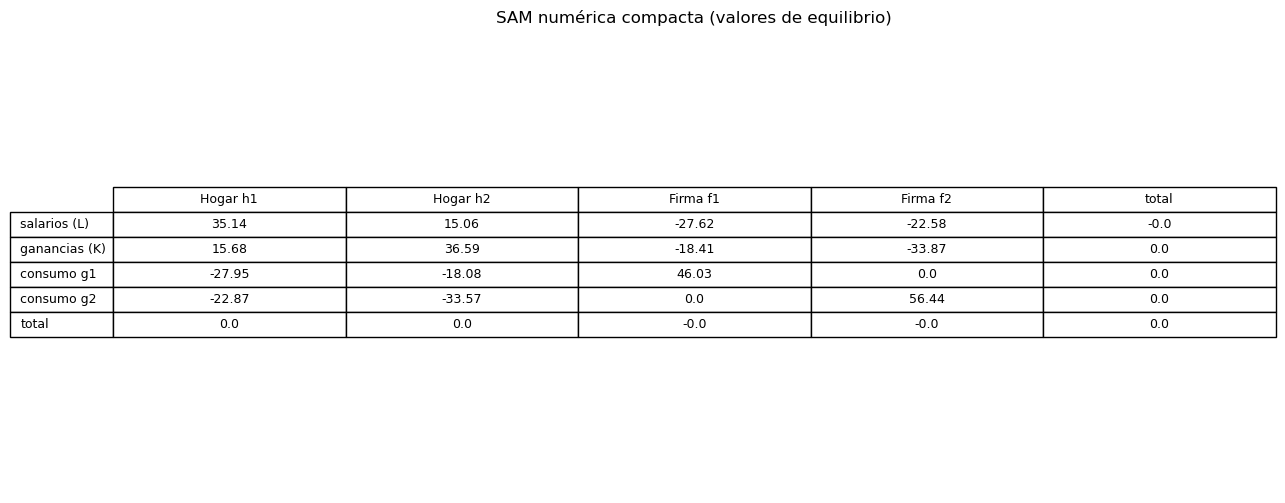

In [1]:
# ===============================================
# CGE 2x2x2 (2 bienes/firmas, 2 hogares, 2 factores)
# SAM simbólica + resolución del equilibrio general
# Cobb-Douglas en consumo y producción - economía cerrada
# Formato SAM compacto tipo: salarios/ganancias/consumos
# ===============================================

import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.optimize import root
import matplotlib.pyplot as plt

# ---------- Sets ----------
goods   = ["g1","g2"]        # g1 producido por f1, g2 por f2
firms   = ["f1","f2"]
factors = ["L","K"]
hh      = ["h1","h2"]

# ---------- Parámetros (puedes editarlos) ----------
@dataclass
class Tech:
    A: float      # productividad total
    aL: float     # exponente de trabajo
    aK: float     # exponente de capital
# (aL + aK = 1 para CRS Cobb-Douglas)

tech = {
    "f1": Tech(A=1.0, aL=0.6, aK=0.4),
    "f2": Tech(A=1.2, aL=0.4, aK=0.6),
}

# Preferencias Cobb-Douglas de los hogares (acciones presupuestales en cada bien, suman 1 por hogar)
beta = {
    "h1": {"g1": 0.55, "g2": 0.45},
    "h2": {"g1": 0.35, "g2": 0.65},
}

# Dotaciones de factores (totales de la economía)
Lbar, Kbar = 100.0, 100.0

# Participación de la propiedad de factores por hogar (cada columna suma 1)
theta = pd.DataFrame(
    data=[[0.7, 0.3],   # h1 recibe 70% del trabajo, 30% del capital
          [0.3, 0.7]],  # h2 recibe 30% del trabajo, 70% del capital
    index=hh, columns=factors
)

# ---------- Utilidades auxiliares ----------
def unit_cost_CobbDouglas(wL, wK, aL, aK, A):
    # Costo unitario para y = A * L^aL * K^aK con precios de factores wL,wK:
    # c(w) = (wL^aL * wK^aK) / (A * aL^aL * aK^aK)
    return (wL**aL * wK**aK) / (A * (aL**aL) * (aK**aK))

def incomes(wL, wK):
    # Ingresos factoriales
    Y_L = wL * Lbar
    Y_K = wK * Kbar
    Ih = {}
    for h in hh:
        Ih[h] = theta.loc[h,"L"] * Y_L + theta.loc[h,"K"] * Y_K
    return Ih

def demands(Ih, p):
    # Demanda Cobb-Douglas: x_{h,g} = beta_{h,g} * I_h / p_g
    Xhg = {h: {} for h in hh}
    for h in hh:
        for g in goods:
            Xhg[h][g] = beta[h][g] * Ih[h] / p[g]
    # Demanda total por bien
    Yd = {g: sum(Xhg[h][g] for h in hh) for g in goods}
    return Xhg, Yd

def factor_demands_from_revenue(Y, p, wL, wK):
    # Con Cobb-Douglas y beneficios cero:
    # pago al trabajo de la firma j: aL_j * p_j * Y_j = wL * L_j  => L_j = aL_j * p_j * Y_j / wL
    # pago al capital:               aK_j * p_j * Y_j = wK * K_j  => K_j = aK_j * p_j * Y_j / wK
    Lj, Kj = {}, {}
    for j,g in zip(firms, goods):
        aL, aK = tech[j].aL, tech[j].aK
        Lj[j] = aL * p[g] * Y[g] / wL
        Kj[j] = aK * p[g] * Y[g] / wK
    return Lj, Kj

# ---------- Sistema de equilibrio ----------
# Normalización: p1 = 1 (numeraire)
# Ecuaciones:
# (1) 1 - c1(wL,wK) = 0     (costo unitario del bien 1 igual a su precio normalizado)
# (2) p2 - c2(wL,wK) = 0
# (3) sum_j L_j - Lbar = 0
# (4) sum_j K_j - Kbar = 0
# (5) Y1 - sum_h beta_{h,1} * I_h / p1 = 0      (mercado de bien 1)
# (el mercado de bien 2 se satisface por la ley de Walras)

def equilibrium_system(z):
    # z = [wL, wK, p2, Y1, Y2]
    wL, wK, p2, Y1, Y2 = z
    p = {"g1": 1.0, "g2": p2}

    # (1)-(2) costos unitarios = precios
    c1 = unit_cost_CobbDouglas(wL, wK, tech["f1"].aL, tech["f1"].aK, tech["f1"].A)
    c2 = unit_cost_CobbDouglas(wL, wK, tech["f2"].aL, tech["f2"].aK, tech["f2"].A)
    eq1 = 1.0 - c1
    eq2 = p2  - c2

    # Ingresos hogares y demandas
    Ih = incomes(wL, wK)
    Xhg, Yd = demands(Ih, p)

    # Usos finales (outputs) -> variables Y1,Y2
    Y = {"g1": Y1, "g2": Y2}

    # (3)-(4) Demanda de factores implícita vs dotaciones
    Lj, Kj = factor_demands_from_revenue(Y, p, wL, wK)
    eq3 = (sum(Lj.values()) - Lbar)
    eq4 = (sum(Kj.values()) - Kbar)

    # (5) Mercado de bien 1
    eq5 = Y["g1"] - Yd["g1"]

    return np.array([eq1, eq2, eq3, eq4, eq5], dtype=float)

# --------- Resolver ----------
# Valores iniciales razonables
z0 = np.array([1.0, 1.0, 1.0, 80.0, 80.0], dtype=float)
sol = root(equilibrium_system, z0, method="hybr")

if not sol.success:
    raise RuntimeError(f"No convergió: {sol.message}")

wL, wK, p2, Y1, Y2 = sol.x
p = {"g1": 1.0, "g2": p2}
Ih = incomes(wL, wK)
Xhg, Yd = demands(Ih, p)
Lj, Kj = factor_demands_from_revenue({"g1": Y1, "g2": Y2}, p, wL, wK)

# ---------- Reporte de equilibrio ----------
print("\n=== Precios y salarios de equilibrio ===")
print(f"p1 (numeraire) = {p['g1']:.4f}")
print(f"p2             = {p['g2']:.4f}")
print(f"w_L            = {wL:.4f}")
print(f"w_K            = {wK:.4f}")

print("\n=== Producción (outputs) ===")
print(f"Y1 (bien g1)   = {Y1:.4f}")
print(f"Y2 (bien g2)   = {Y2:.4f}")

print("\n=== Demanda agregada por bien (debe igualar output por Walras) ===")
for g in goods:
    print(f"Demanda total {g}: {Yd[g]:.4f}")

print("\n=== Ingresos de hogares ===")
for h in hh:
    print(f"I_{h} = {Ih[h]:.4f}")

print("\n=== Uso de factores por firma ===")
for j,g in zip(firms, goods):
    print(f"{j}: L={Lj[j]:.4f}, K={Kj[j]:.4f}")

# ---------- SAM numérica "completa" (interna, no mostrada) ----------
accounts = firms + factors + hh
num_SAM = pd.DataFrame(0.0, index=accounts, columns=accounts)

# Consumo de hogares -> ingreso de firmas
for h in hh:
    for j,g in zip(firms, goods):
        num_SAM.loc[j, h] = beta[h][g] * Ih[h]  # gasto nominal de h en g

# Pagos factoriales desde firmas (comparten ingresos según exponentes)
for j,g in zip(firms, goods):
    rev = p[g] * (Y1 if g=="g1" else Y2)
    aL, aK = tech[j].aL, tech[j].aK
    num_SAM.loc["L", j] = aL * rev
    num_SAM.loc["K", j] = aK * rev

# Factores pagan a hogares (según propiedad)
Y_L, Y_K = wL * Lbar, wK * Kbar
for h in hh:
    num_SAM.loc[h, "L"] = theta.loc[h,"L"] * Y_L
    num_SAM.loc[h, "K"] = theta.loc[h,"K"] * Y_K

# ---------- Chequeo contable SAM (opcional) ----------
row_sums = num_SAM.sum(axis=1)
col_sums = num_SAM.sum(axis=0)

print("\n=== Chequeo contable SAM (filas vs columnas) ===")
chk = pd.DataFrame({"Ingresos(fila)": row_sums, "Pagos(col)": col_sums, "Dif": row_sums - col_sums})
print(chk)

# ============================================================
#  SAM COMPACTA: FORMATO TIPO
#  filas  : salarios, ganancias, consumo g1, consumo g2, total
#  columnas: Hogar h1, Hogar h2, Firma f1, Firma f2, total
# ============================================================

# ---------- SAM simbólica compacta ----------
# Usamos nombres consistentes con la construcción de num_SAM:
# - INC_h*_L, INC_h*_K: ingresos factoriales a hogares
# - W_L_f*, W_K_f*: pagos desde firmas a factores
# - C_h*_g*: consumo de hogar h en bien g

sym_data = [
    # salarios (L)
    ["INC_h1_L", "INC_h2_L", "-W_L_f1", "-W_L_f2"],
    # ganancias (K) -> las interpretamos como pagos a capital
    ["INC_h1_K", "INC_h2_K", "-W_K_f1", "-W_K_f2"],
    # consumo g1
    ["-C_h1_g1", "-C_h2_g1", "C_h1_g1 + C_h2_g1", "0"],
    # consumo g2
    ["-C_h1_g2", "-C_h2_g2", "0", "C_h1_g2 + C_h2_g2"],
]

# construir fila "total" como suma simbólica por columna
totals_sym = []
for col in range(4):
    s = f"{sym_data[0][col]} + {sym_data[1][col]} + {sym_data[2][col]} + {sym_data[3][col]}"
    totals_sym.append(s)
totals_sym.append("0")  # total de la columna "total"

# añadir columna "total" a cada fila
sym_data_with_total = []
for row in sym_data:
    # row_total es simplemente la suma simbólica de esa fila
    row_total = f"{row[0]} + {row[1]} + {row[2]} + {row[3]}"
    sym_data_with_total.append(row + [row_total])

# añadir fila "total"
sym_data_with_total.append(totals_sym)

row_labels = ["salarios (L)", "ganancias (K)", "consumo g1", "consumo g2", "total"]
col_labels = ["Hogar h1", "Hogar h2", "Firma f1", "Firma f2", "total"]

sam_sym_df = pd.DataFrame(sym_data_with_total, index=row_labels, columns=col_labels)

print("\n=== SAM simbólica compacta (estructural) ===")
print(sam_sym_df)

# Plot simbólico
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=sam_sym_df.values,
    colLabels=sam_sym_df.columns,
    rowLabels=sam_sym_df.index,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.5, 1.5)
plt.title("SAM simbólica compacta")
plt.show()

# ---------- SAM numérica compacta ----------
# Construimos la misma estructura pero a partir de num_SAM

# salarios (L): hogares reciben +, firmas pagan -
salarios_num = [
    num_SAM.loc["h1", "L"],               # Hogar h1
    num_SAM.loc["h2", "L"],               # Hogar h2
    -num_SAM.loc["L",  "f1"],             # Firma f1
    -num_SAM.loc["L",  "f2"],             # Firma f2
]

# ganancias (K): interpretamos como renta de capital
ganancias_num = [
    num_SAM.loc["h1", "K"],
    num_SAM.loc["h2", "K"],
    -num_SAM.loc["K",  "f1"],
    -num_SAM.loc["K",  "f2"],
]

# consumo g1: hogares pagan (-), firma f1 recibe (+)
cons_g1_num = [
    -num_SAM.loc["f1", "h1"],                           # Hogar h1
    -num_SAM.loc["f1", "h2"],                           # Hogar h2
    num_SAM.loc["f1", "h1"] + num_SAM.loc["f1", "h2"],  # Firma f1
    0.0,                                                # Firma f2
]

# consumo g2: hogares pagan (-), firma f2 recibe (+)
cons_g2_num = [
    -num_SAM.loc["f2", "h1"],
    -num_SAM.loc["f2", "h2"],
    0.0,
    num_SAM.loc["f2", "h1"] + num_SAM.loc["f2", "h2"],
]

data_num = [salarios_num, ganancias_num, cons_g1_num, cons_g2_num]

# añadir columna "total" como suma numérica por fila
data_num_with_total = []
for row in data_num:
    row_total = sum(row)
    data_num_with_total.append(row + [row_total])

# fila "total": suma por columna de las 4 primeras filas
col_totals_num = []
for col in range(4):
    col_sum = sum(data_num[row][col] for row in range(4))
    col_totals_num.append(col_sum)
col_totals_num.append(0.0)  # total de la columna "total"

data_num_with_total.append(col_totals_num)

sam_num_df = pd.DataFrame(data_num_with_total, index=row_labels, columns=col_labels)

print("\n=== SAM numérica compacta ===")
print(sam_num_df)

# Plot numérico
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=np.round(sam_num_df.values, 2),
    colLabels=sam_num_df.columns,
    rowLabels=sam_num_df.index,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.5, 1.5)
plt.title("SAM numérica compacta (valores de equilibrio)")
plt.show()
